In [1]:
# Remove from public version
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from funcshape.networks import CurveReparametrizer
from funcshape.layers.sineseries import SineSeries
from funcshape.logging import Logger
from funcshape.reparametrize import reparametrize
from funcshape.utils import col_linspace
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

In [3]:
def gaussian(t, p):
    out = np.zeros(t.shape)
    for i in range(1,p+1):
        zi = np.random.normal(1, 0.1)
        mean = (2*i-1)/(2*p)
        sigma = 1/(3*p)
        factor = 1/(2*(sigma**2))
        phi =  np.exp(-factor*(t-mean)**2)
        out += zi*phi

    return out

def warping(t):
    a = np.random.uniform(-3, 3)
    if a==0:
        gam = t
    else:
        gam = (np.exp(a*t)-1)/(np.exp(a)-1)

    return gam

class Function:
    def __init__(self, x, fx):
        self.x = x
        self.fx = fx
        coeffs = natural_cubic_spline_coeffs(self.x, self.fx)
        self.spline = NaturalCubicSpline(coeffs)

    def __call__(self, x):
        return self.spline.evaluate(x)

    def derivative(self, x, h=None):
        return self.spline.derivative(x, order=1)
    
    def compose(self, f):
        fx = f(self.x)
        y = self.spline.evaluate(fx).squeeze(-1)
        
        return Function(self.x, y)

### Display Figures Before Reparametrization

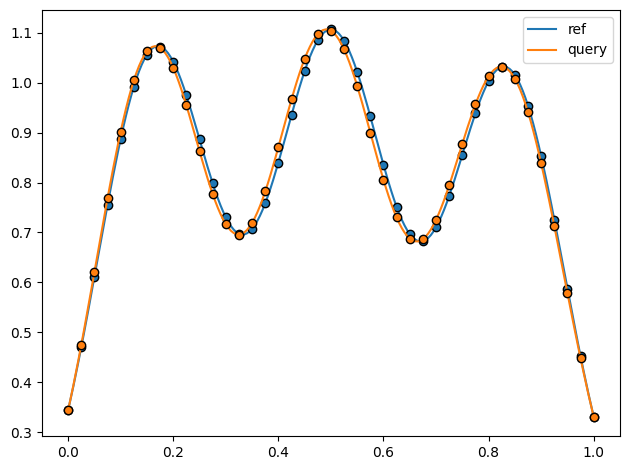

In [4]:
# Get function and a random warping function
time = torch.linspace(0,1,100)
t_ = np.linspace(0,1, len(time))
gamma = warping(t_)
f1_ = gaussian(t_, 3) #np.random.randint(1,3))
f2_ = gaussian(gamma, 2)

# Define function objects 
f1 = Function(time, torch.from_numpy(f1_).reshape(-1,1))
# f2 = Function(time, torch.from_numpy(f2_).reshape(-1,1))
diff = Function(time, torch.from_numpy(gamma).reshape(-1,1))
f2 = f1.compose(diff)
f2_ = f2(time).squeeze().numpy()

def plot_function(f, npoints=201, dotpoints=None, ax=None, **kwargs):
    x = torch.linspace(0, 1, npoints).squeeze()
    fx = f(x).squeeze()

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x, fx, **kwargs)

    if dotpoints is not None:
        x = torch.linspace(0, 1, dotpoints).squeeze()
        fx = f(x).squeeze()
        ax.plot(
            x,
            fx,
            c=ax.lines[-1].get_color(),
            ls="none",
            marker="o",
            markeredgecolor="black",
        )

    return ax

fig, ax =plt.subplots()
plot_function(f1, dotpoints=41, ax=ax, label="ref")
plot_function(f2, dotpoints=41, ax=ax, label="query")
ax.legend()
plt.tight_layout()
plt.show()

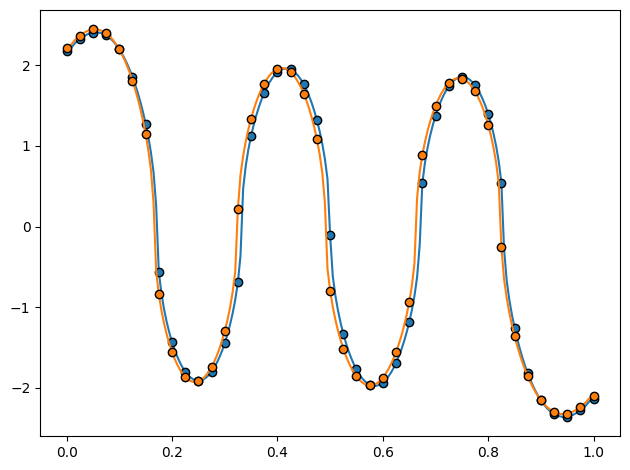

In [5]:
# Get SRSF maps
class SRSF:
    """SRSF transformation of functions"""

    def __init__(self, f : Function)-> None:
        self.f = f

    def __call__(self, x, h=None):
        grad = self.f.derivative(x)
        q = grad / torch.sqrt(torch.abs(grad) + 1e-3)
        
        return q
    
q1, q2 = SRSF(f1), SRSF(f2)
fig, ax =plt.subplots()
plot_function(q1, dotpoints=41, ax=ax)
plot_function(q2, dotpoints=41, ax=ax)
plt.tight_layout()
plt.show()

In [6]:
from funcshape.loss import ShapeDistanceBase 

class FunctionDistance(ShapeDistanceBase):
    def create_point_collection(self, k):
        return col_linspace(0, 1, k)

    def get_determinant(self, network):
        return network.derivative(self.X, self.h)

    def loss_func(self, U, Y):
        error = ((self.Q.squeeze(-1) - torch.sqrt(U + 1e-8) * self.r(Y, self.h).squeeze(-1)) ** 2)
        l2_norm = torch.trapezoid(error.squeeze(), x=self.X.squeeze())
        
        return l2_norm

In [7]:
N_BASIS = 10 
N_LAYERS = 50
LR = 3e-4
N_ITERS = 1000
NUM_DOMAIN_POINTS = 100
N_RESTRATS = 10

# Define loss, optimizer and run reparametrization.
loss_func = FunctionDistance(q1, q2, k=NUM_DOMAIN_POINTS)

best_error = np.inf
for _ in range(N_RESTRATS):
    # Create reparametrization network
    RN = CurveReparametrizer([
        SineSeries(N_BASIS) for i in range(N_LAYERS)
    ])

    optimizer = optim.Adam(RN.parameters(), lr=LR)
    # optimizer = optim.LBFGS(RN.parameters(), lr=LR, max_iter=N_ITERS, line_search_fn="strong_wolfe")
    error = reparametrize(RN, loss_func, optimizer, N_ITERS, Logger(0))

    if error[-1]<best_error:
        best_error = error[-1]
        best_RN = RN
        print("Current best error : %2.4f"%best_error)

    if best_error<1e-3:
        break

# Get plot data to visualize diffeomorphism
best_RN.detach()
x = col_linspace(0, 1, NUM_DOMAIN_POINTS)
y = best_RN(x)

Current best error : 0.7851
Current best error : 0.0198


In [8]:
from apdist import SquareRootSlopeFramework as SRSF_

srsf = SRSF_(t_)
q_ref = srsf.to_srsf(f1_)
q_query = srsf.to_srsf(f2_)
optim_kwargs = {"optim":"DP", "grid_dim":60}
gamma_dp = srsf.get_gamma(q_ref, q_query, **optim_kwargs)


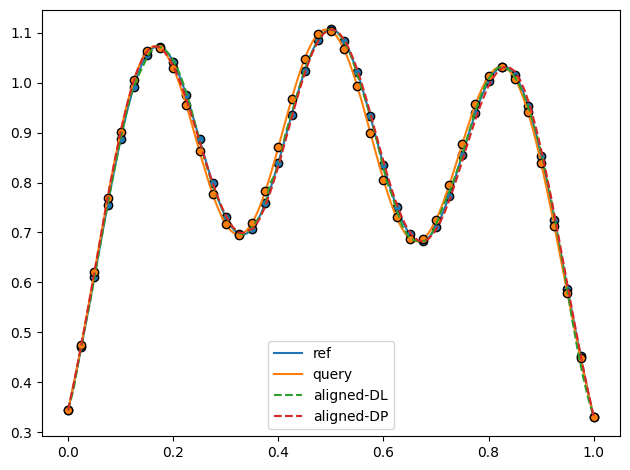

In [9]:
# Plot reparametrized curves and original
fig, ax =plt.subplots()
plot_function(f1, dotpoints=41, ax=ax, label="ref")
plot_function(f2, dotpoints=41, ax=ax, label="query")
f_query_gamma = srsf.warp_f_gamma(f2_, gamma_dp)
ax.plot(x, f2(y).squeeze(), ls='--', label="aligned-DL")
ax.plot(t_, f_query_gamma.squeeze(), ls='--', label="aligned-DP")
ax.legend()
plt.tight_layout()
plt.show()

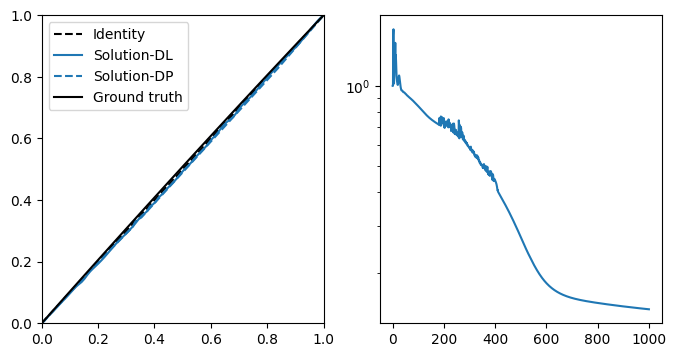

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(t_, t_, label="Identity", color="k", ls='--')
ax1.plot(x, y, label="Solution-DL")
ax1.plot(t_, gamma_dp, label="Solution-DP",
         ls = '--', color=ax1.lines[-1].get_color())
ax1.plot(t_, gamma, label="Ground truth", color="k")
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax2.semilogy(error / error[0])
plt.show()

### Use function from the package

In [28]:
from funcshape.functions import get_warping_function

warping, optim_net, error = get_warping_function(f1, f2)

Current best error : 0.1197
Current best error : 0.0398
Current best error : 0.0293
Current best error : 0.0262
Current best error : 0.0051
torch.Size([1024, 1]) torch.Size([1024, 1])


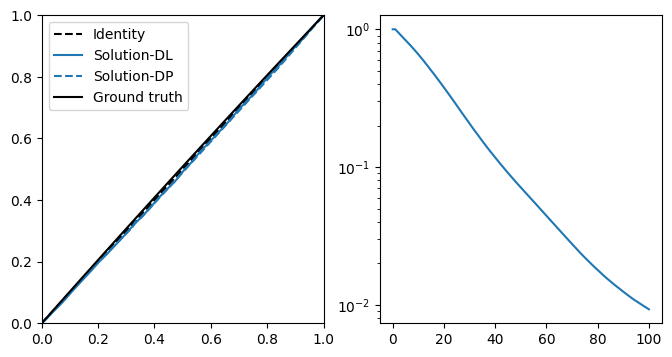

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(t_, t_, label="Identity", color="k", ls='--')
ax1.plot(warping.x, warping.fx, label="Solution-DL")
ax1.plot(t_, gamma_dp, label="Solution-DP",
         ls = '--', color=ax1.lines[-1].get_color())
ax1.plot(t_, gamma, label="Ground truth", color="k")
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax2.semilogy(error / error[0])
plt.show()